In [1]:
import numpy as np
import cv2
import misc
from RL_networks import Stand_alone_net
import pickle


In [2]:
from sklearn.metrics import confusion_matrix

### Naive Random Walk, judt push the images to the networks and see if they can learn to extract information fro m a random combination of images.
In this implimintation we have the Syclop run a random walk on the image, we will see if a basic CNN or RNN network can work with a changing path over the images. 
<br> For each image a new, random, path will be initialized.
<br> This does not work at all, the networks run poorly compared to the case when the same random path is used for all images. 
<br> 

In [3]:
import importlib
importlib.reload(misc)

<module 'misc' from '/home/labs/ahissarlab/orra/imagewalker/misc.py'>

In [4]:

from __future__ import division, print_function, absolute_import

# PyTorch libraries and modules
import torchvision
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
import torch.nn as nn
from mnist import MNIST

mnist = MNIST('/home/labs/ahissarlab/orra/datasets/mnist')
images, labels = mnist.load_training()

# Training Parameters
learning_rate = 0.001
num_steps = 1000
batch_size = 128

validation_index=-5000

# Network Parameters
size=None
padding_size=(128,128)
# num_input = padding_size[0]*padding_size[1] # MNIST data input (img shape: 28*28)
num_classes = None 
# dropout = 0.25 # Dropout, probability to drop a unit

import matplotlib.pyplot as plt
%matplotlib notebook
import SYCLOP_env as syc



In [5]:
#Define function for low resolution lens on syclop
def bad_res101(img,res):
    sh=np.shape(img)
    dwnsmp=cv2.resize(img,res, interpolation = cv2.INTER_CUBIC)
    upsmp = cv2.resize(dwnsmp,sh, interpolation = cv2.INTER_CUBIC)
    return upsmp

<IPython.core.display.Javascript object>


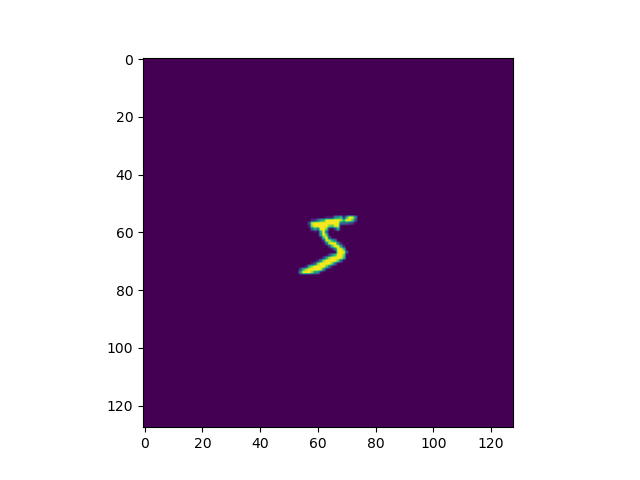

In [5]:
plt.figure()
plt.imshow(misc.build_mnist_padded(1./256*np.reshape(images[0],[1,28,28])))

In [48]:
img=misc.build_mnist_padded(1./256*np.reshape(images[45],[1,28,28]))

In [49]:
scene = syc.Scene(image_matrix=img)
sensor = syc.Sensor(winx=56,winy=56,centralwinx=28,centralwiny=28)
agent = syc.Agent(max_q = [scene.maxx-sensor.hp.winx,scene.maxy-sensor.hp.winy])

In [41]:
starting_point = np.array([agent.max_q[0]//2,agent.max_q[1]//2])
steps  = []
for j in range(5):
    steps.append(starting_point*1)
    starting_point += np.random.randint(-5,5,2) 

q_sequence = np.array(steps).astype(int)
q_sequence

array([[36, 36],
       [33, 37],
       [34, 39],
       [35, 39],
       [36, 40]])

In [50]:
sensor.hp.resolution_fun = lambda x: bad_res101(x,(28,28))
imim=[]
dimim=[]
agent.set_manual_trajectory(manual_q_sequence=q_sequence)
for t in range(10):
    agent.manual_act()
    sensor.update(scene, agent)
    imim.append(sensor.central_frame_view)
    dimim.append(sensor.central_dvs_view)
    

<IPython.core.display.Javascript object>


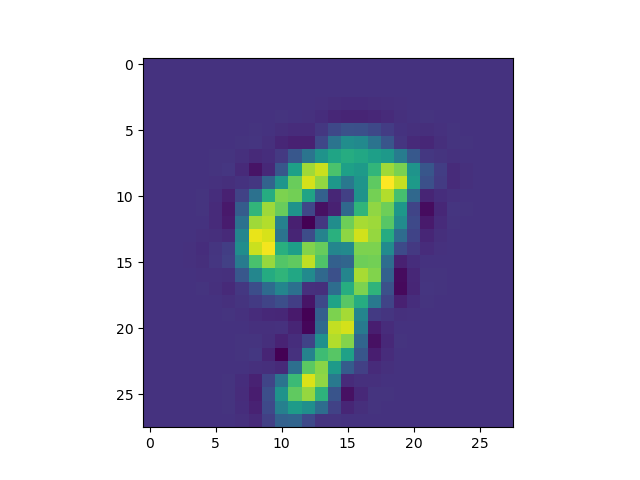

<IPython.core.display.Javascript object>


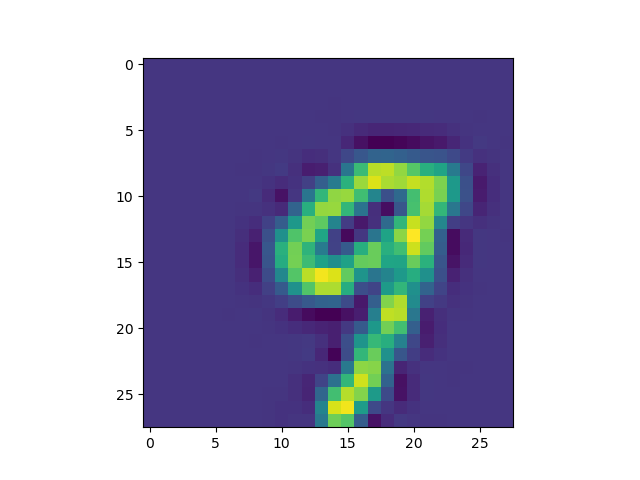

<IPython.core.display.Javascript object>


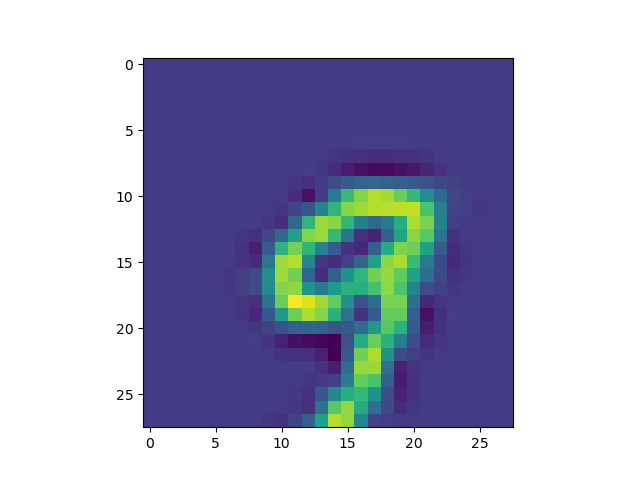

<IPython.core.display.Javascript object>


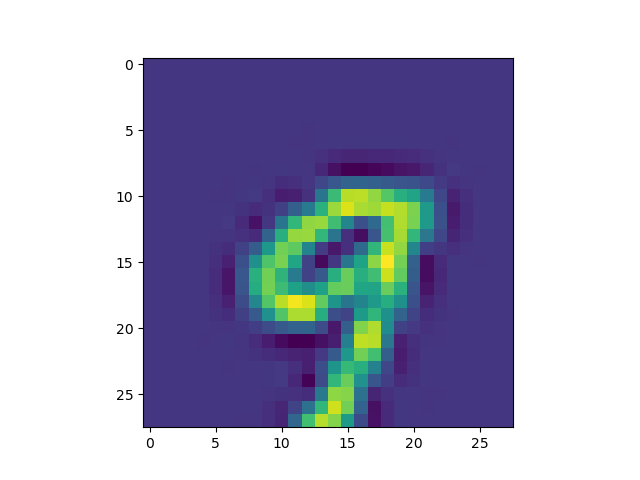

<IPython.core.display.Javascript object>


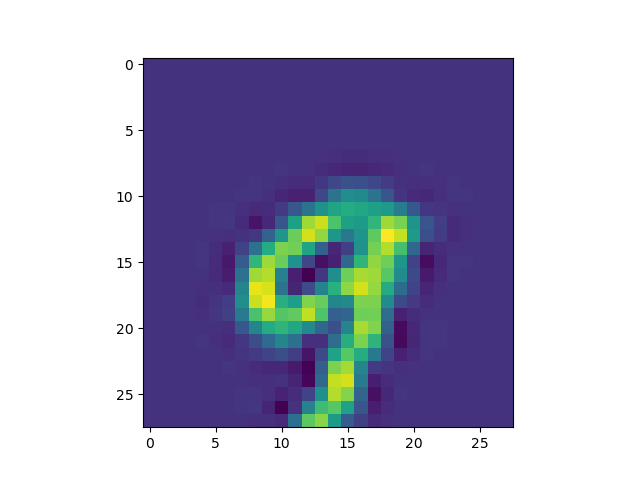

In [51]:
for i in range(5):
    plt.figure()
    plt.imshow(imim[i])

### Create a Dataset from the Syclops visual inputs
We are starting with a simple time series where the syclop starts from the same starting point, at the middle of the img on the x axis and the middle - 10 pixles on the y axis - (middle_point, middle_point - 10)
<br> Each time step the syclop will move one pixle up on the y axis, to a final point at (middle_point, middle_point + 10) and make a circular movement in the x direction.
<br> 

In [6]:
def create_dataset(images, labels, res, sample = 5, mixed_state = True, dvs = False):
    '''
    Creates a torch dataloader object of syclop outputs 
    from a list of images and labels.
    
    Parameters
    ----------
    images : List object holding the images to proces
    labels : List object holding the labels
    res : resolution dawnsampling factor - to be used in cv.resize(orig_img, res)
    sample: the number of samples to have in syclop
    mixed_state : if False, use the same trajectory on every image.

    Returns
    -------
    train_dataloader, test_dataloader - torch DataLoader class objects

    '''
    count = 0
    ts_images = []
    dvs_images = []
    count = 0
    #create subplot to hold examples from the dataset
    fig, ax = plt.subplots(2,5)
    i = 0 #indexises for the subplot for image and for syclop vision
    for img in images:
        orig_img = np.reshape(img,[28,28])
        #Set the padded image
        img=misc.build_mnist_padded(1./256*np.reshape(img,[1,28,28]))
        
        if count < 5:
            ax[0,i].imshow(orig_img) 
            ax[0,i].set_title(labels[count])
        #Set the sensor and the agent
        scene = syc.Scene(image_matrix=img)
        sensor = syc.Sensor(winx=56,winy=56,centralwinx=28,centralwiny=28)
        agent = syc.Agent(max_q = [scene.maxx-sensor.hp.winx,scene.maxy-sensor.hp.winy])
        #Setting the coordinates to visit
        starting_point = np.array([agent.max_q[0]//2,agent.max_q[1]//2])
        
        steps  = []
        for j in range(5):
            steps.append(starting_point*1)
            starting_point += np.random.randint(-5,5,2) 
        
        if mixed_state:
            q_sequence = np.array(steps).astype(int)
        else:
            if count == 0:
                q_sequence = np.array(steps).astype(int)
        #Setting the resolution function - starting with the regular resolution
        sensor.hp.resolution_fun = lambda x: bad_res101(x,(res,res))
        #Create empty lists to store the syclops outputs
        imim=[]
        dimim=[]
        agent.set_manual_trajectory(manual_q_sequence=q_sequence)
        #Run Syclop for 20 time steps
        for t in range(5):
            agent.manual_act()
            sensor.update(scene, agent)
            imim.append(sensor.central_frame_view)
            dimim.append(sensor.central_dvs_view)
        #Create a unified matrix from the list
        if count < 5:
            ax[1,i].imshow(imim[0]) 
            ax[1,i].set_title(labels[count])
            i+=1
            

        imim = np.array(imim)
        dimim = np.array(dimim)
        #Add current proccessed image to lists
        ts_images.append(imim)
        dvs_images.append(dimim)
        count += 1
        


    ts_train = ts_images[:55_000]
    train_labels = labels[:55_000]
    ts_val = ts_images[55_000:]
    val_labels = labels[55_000:]

    dvs_train = dvs_images[:55_000]
    dvs_val = dvs_images[55_000:]
    
    class mnist_dataset(Dataset):
        def __init__(self, data, labels, transform = None):

            self.data = data
            self.labels = labels

            self.transform = transform
        def __len__(self):
            return len(self.data)

        def __getitem__(self, idx):
            '''
            args idx (int) :  index

            returns: tuple(data, label)
            '''
            data = self.data[idx]
            label = self.labels[idx]

            if self.transform:
                data = self.transform(data)
                return data, label
            else:
                return data, label

        def dataset(self):
            return self.data
        def labels(self):
            return self.labels


    if dvs:
        train_dataset = mnist_dataset(dvs_train, train_labels)
        test_dataset = mnist_dataset(dvs_val, val_labels)
    else:
        train_dataset = mnist_dataset(ts_train, train_labels)
        test_dataset = mnist_dataset(ts_val, val_labels)
    batch = 64
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = batch, shuffle = True)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = batch, shuffle = False)

    
    return train_dataloader, test_dataloader, test_dataset

In [7]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(5,16,3,stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16,32,3, stride=1, padding=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32,16,3,stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(16)
        
        self.pool = nn.MaxPool2d(2)
        
        #After the layers and pooling the first two we should get 
        # 16,3,3
        #Flatting it we get:
        # 144
        
        self.fc1 = nn.Linear(8*8*16,64)
        self.fc2 = nn.Linear(64,10)
        
        self.relu = nn.ReLU()
        
    def forward(self, img):
        
        img = self.pool(self.relu(self.bn1(self.conv1(img.double()))))
        img = self.pool(self.relu(self.bn2(self.conv2(img))))
        img = self.relu(self.bn3(self.conv3(img)))        
        #print(img.shape)
        img = img.view(img.shape[0],8*8*16)
        img = self.relu(self.fc1(img))
        img = self.fc2(img)
        
        return img

In [8]:
class CNN_one_layer(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,16,3,stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16,32,3, stride=1, padding=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32,16,3,stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(16)
        
        self.pool = nn.MaxPool2d(2)
        
        #After the layers and pooling the first two we should get 
        # 16,3,3
        #Flatting it we get:
        # 144
        
        self.fc1 = nn.Linear(8*8*16,64)
        self.fc2 = nn.Linear(64,10)
        
        self.relu = nn.ReLU()
        
    def forward(self, img):
        img = img[:,0,:,:]
        img = img.unsqueeze(1)
        img = self.pool(self.relu(self.bn1(self.conv1(img.double()))))
        img = self.pool(self.relu(self.bn2(self.conv2(img))))
        img = self.relu(self.bn3(self.conv3(img)))        
        #print(img.shape)
        img = img.view(img.shape[0],8*8*16)
        img = self.relu(self.fc1(img))
        img = self.fc2(img)
        
        return img

In [9]:
def train(train_dataloader, test_dataloader, net, epochs = 10):

    lr = 3e-3
    #net = CNN().double()
    optimizer = Adam(net.parameters(), lr = lr)
    loss_func = nn.CrossEntropyLoss()
    if torch.cuda.is_available():
        net = net.cuda()
    
    train_loss = []
    test_loss = []
    test_accur = []
    for epoch in range(epochs):

        batch_loss = []
        for batch_idx, (data,targets) in enumerate(train_dataloader):
            if net.__class__.__name__ == 'RNN_Net':
                data = data.unsqueeze(2)
            if torch.cuda.is_available():
                data = data.to('cuda', non_blocking=True)
                targets = targets.to('cuda', non_blocking = True)
            #print(batch_idx, data.shape, targets.shape)

            optimizer.zero_grad()
            output = net(data.double())
            loss = loss_func(output, targets)
            loss.backward()
            optimizer.step()
            batch_loss.append(loss.item())


        train_loss.append(np.mean(batch_loss))

        if epoch%1 == 0:
            correct = 0
            test_batch_loss = []
            test_accuracy = []
            for batch_idx, (test_data,test_targets) in enumerate(test_dataloader):
                if net.__class__.__name__ == 'RNN_Net':
                    test_data = test_data.unsqueeze(2)
                if torch.cuda.is_available():
                    test_data = test_data.to('cuda', non_blocking=True)
                    test_targets = test_targets.to('cuda', non_blocking = True)
                #print(batch_idx, data.shape, targets.shape)

                test_output = net(test_data)
                loss = loss_func(test_output, test_targets)
                test_batch_loss.append(loss.item())
                test_pred = test_output.data.max(1, keepdim = True)[1]
                correct = test_pred.eq(test_targets.data.view_as(test_pred)).sum()
                test_accuracy.append(100.*correct.to('cpu')/len(test_targets))

            print('Net',net.__class__.__name__,'Epoch : ',epoch+1, '\t', 'loss :', loss.to('cpu').item(), 'accuracy :',np.mean(test_accuracy) )
            test_loss.append(np.mean(test_batch_loss))
            test_accur.append(np.mean(test_accuracy))
    
    return train_loss, test_loss, test_accur

In [10]:
class RNN_Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,16,3,stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16,32,3, stride=1, padding=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32,16,3,stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(16)
        
        self.pool = nn.MaxPool2d(2)
        
        #After the layers and pooling the first two we should get 
        # 16,3,3
        #Flatting it we get:
        # 144
        self.gru = nn.GRU(8*8*16,100)
        self.fc1 = nn.Linear(100,10)
        #self.fc2 = nn.Linear(6,10)
        
        self.relu = nn.ReLU()
        
    def forward(self, data):
        hn = torch.zeros([1,data.shape[0],100]).double()
        if torch.cuda.is_available():
            hn = hn.to('cuda')
        #print(data.shape)
        for i in range(data.shape[1]):
            img = data[:,i,:,:,:]
            #print(img.shape)
            #plt.figure()
            #plt.imshow(img[0][0])
            img = self.pool(self.relu(self.bn1(self.conv1(img.double()))))
            img = self.pool(self.relu(self.bn2(self.conv2(img))))
            img = self.relu(self.bn3(self.conv3(img)))        
            img = img.view(img.shape[0],8*8*16)
            out, hn = self.gru(img.unsqueeze(0),hn)
            #print(out.shape)
        output = self.fc1(out[0, :, :])
        
        
        return output

In [11]:
class RNN_Net2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,4,3,stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16,32,3, stride=1, padding=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32,16,3,stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(16)
        
        self.pool = nn.MaxPool2d(2)
        
        #After the layers and pooling the first two we should get 
        # 16,3,3
        #Flatting it we get:
        # 144
        self.gru = nn.GRU(8*8*16,100, batch_first=True)
        self.fc1 = nn.Linear(100,10)
        #self.fc2 = nn.Linear(6,10)
        
        self.relu = nn.ReLU()
        
    def forward(self, data):
        batch_size, timesteps, C, H, W = data.size()
        img = datax.view(batch_size * timesteps, C, H, W)
        img = self.pool(self.relu(self.bn1(self.conv1(img.double()))))
        img = self.pool(self.relu(self.bn2(self.conv2(img))))
        img = self.relu(self.bn3(self.conv3(img)))        
        print(img.shape)
        img = img.view(img.shape[0],img.shape[1],8*8*16)
        out, hn = self.gru(img)
        output = self.fc1(hn.squeeze(0))
        
        
        return output

### See the fluctuation differences when we run on the same trajectory and see set the reandom seed

<IPython.core.display.Javascript object>


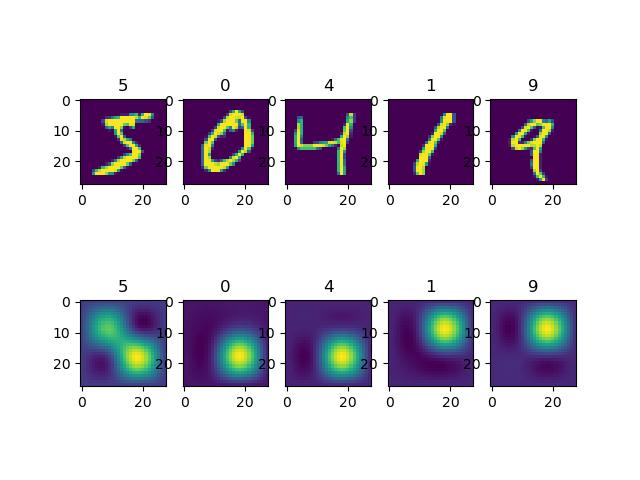

Net RNN_Net Epoch :  1 	 loss : 0.4201945648938121 accuracy : 86.43196
Net RNN_Net Epoch :  2 	 loss : 0.36510979151541856 accuracy : 88.25158
Net RNN_Net Epoch :  3 	 loss : 0.08018550603315767 accuracy : 88.68671
Net RNN_Net Epoch :  4 	 loss : 0.12140494167960339 accuracy : 88.94383


<IPython.core.display.Javascript object>


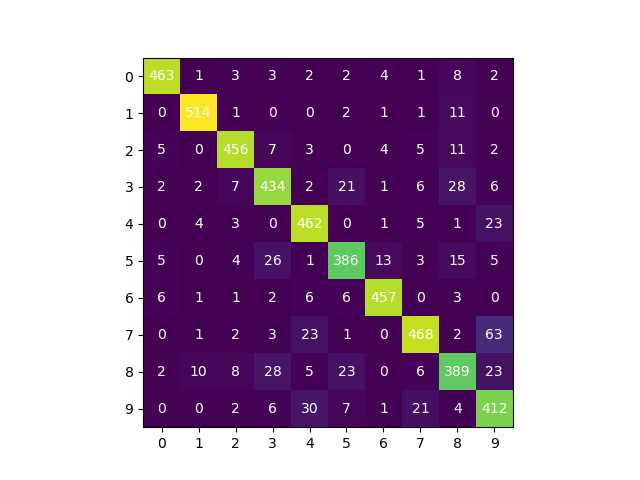

Net RNN_Net Epoch :  1 	 loss : 0.47122531099620524 accuracy : 86.07595
Net RNN_Net Epoch :  2 	 loss : 0.388882124065918 accuracy : 87.67801
Net RNN_Net Epoch :  3 	 loss : 0.24345886319826918 accuracy : 88.62737
Net RNN_Net Epoch :  4 	 loss : 0.18928190983478765 accuracy : 88.52848


<IPython.core.display.Javascript object>


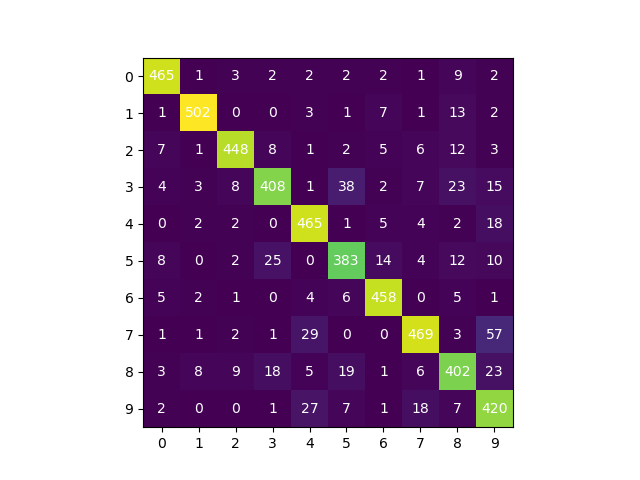

Net RNN_Net Epoch :  1 	 loss : 0.273683979376472 accuracy : 86.07595
Net RNN_Net Epoch :  2 	 loss : 0.15123461853166675 accuracy : 87.79668
Net RNN_Net Epoch :  3 	 loss : 0.1502467017553617 accuracy : 88.17247
Net RNN_Net Epoch :  4 	 loss : 0.07850161503370771 accuracy : 89.02294


<IPython.core.display.Javascript object>


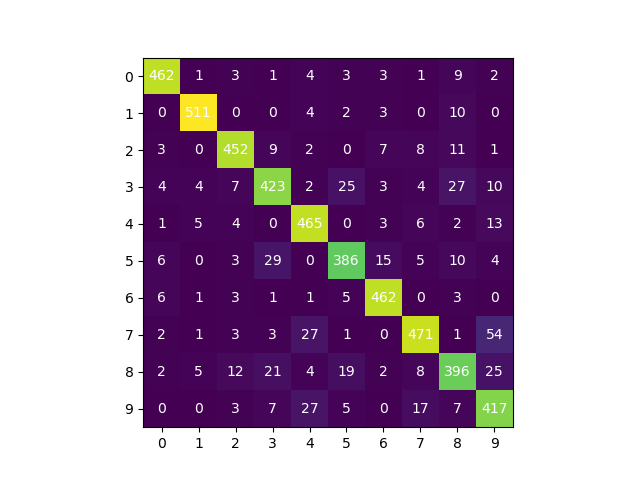

Net RNN_Net Epoch :  1 	 loss : 0.440632640250479 accuracy : 86.095726
Net RNN_Net Epoch :  2 	 loss : 0.2522597009577679 accuracy : 87.38133
Net RNN_Net Epoch :  3 	 loss : 0.09723316014328116 accuracy : 88.66693
Net RNN_Net Epoch :  4 	 loss : 0.13065503884647678 accuracy : 89.69541


<IPython.core.display.Javascript object>


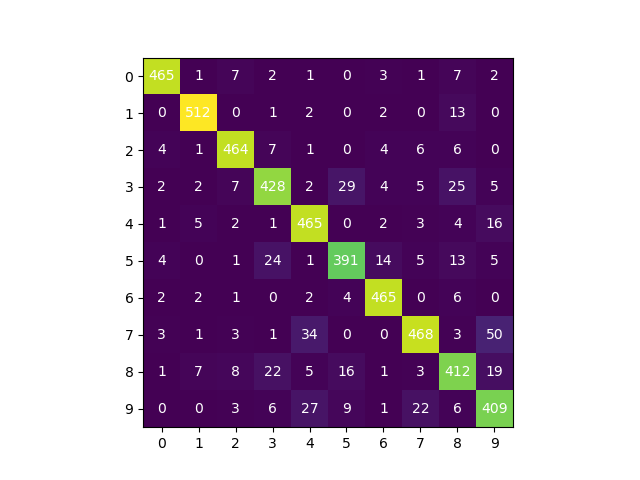

Net RNN_Net Epoch :  1 	 loss : 0.5081585157994646 accuracy : 86.05617
Net RNN_Net Epoch :  2 	 loss : 0.2704250902267751 accuracy : 87.42088
Net RNN_Net Epoch :  3 	 loss : 0.150268742558204 accuracy : 88.508705
Net RNN_Net Epoch :  4 	 loss : 0.05023637385696971 accuracy : 88.48892


<IPython.core.display.Javascript object>


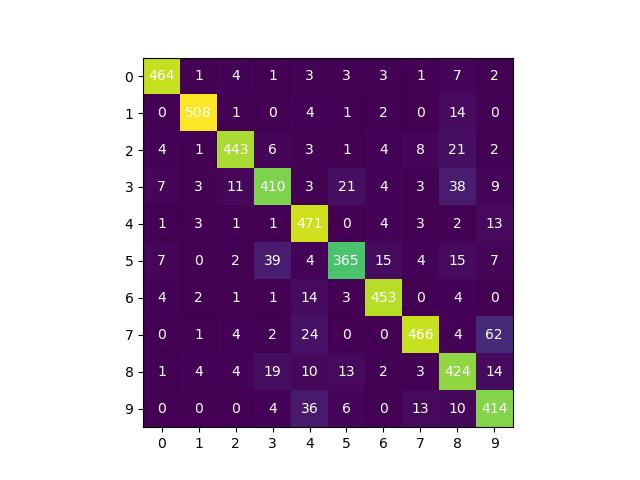

Net RNN_Net Epoch :  1 	 loss : 0.3576564987699926 accuracy : 86.35285
Net RNN_Net Epoch :  2 	 loss : 0.17110310183760674 accuracy : 87.81645
Net RNN_Net Epoch :  3 	 loss : 0.04527450970677553 accuracy : 88.74605
Net RNN_Net Epoch :  4 	 loss : 0.051405130078086954 accuracy : 89.16139


<IPython.core.display.Javascript object>


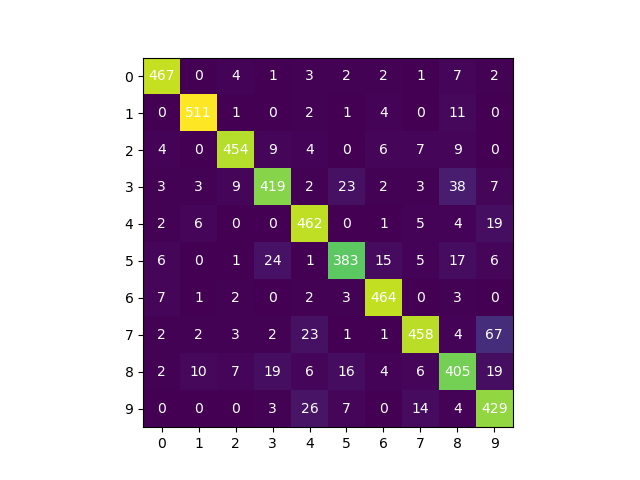

Net RNN_Net Epoch :  1 	 loss : 0.3670710627288076 accuracy : 86.60997
Net RNN_Net Epoch :  2 	 loss : 0.23723724757440307 accuracy : 87.9549
Net RNN_Net Epoch :  3 	 loss : 0.2144310563465133 accuracy : 88.52848
Net RNN_Net Epoch :  4 	 loss : 0.13216631086452899 accuracy : 89.537186


<IPython.core.display.Javascript object>


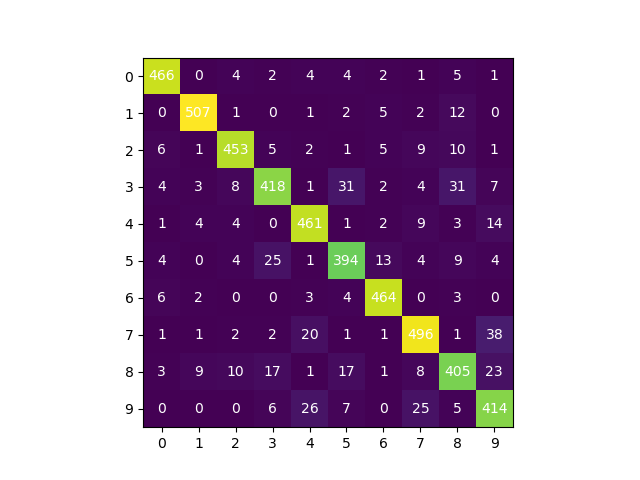

Net RNN_Net Epoch :  1 	 loss : 0.26174959641474715 accuracy : 86.60997
Net RNN_Net Epoch :  2 	 loss : 0.24929459052591438 accuracy : 87.697784
Net RNN_Net Epoch :  3 	 loss : 0.21274759574228574 accuracy : 88.80538
Net RNN_Net Epoch :  4 	 loss : 0.05973355703276064 accuracy : 88.6076


<IPython.core.display.Javascript object>


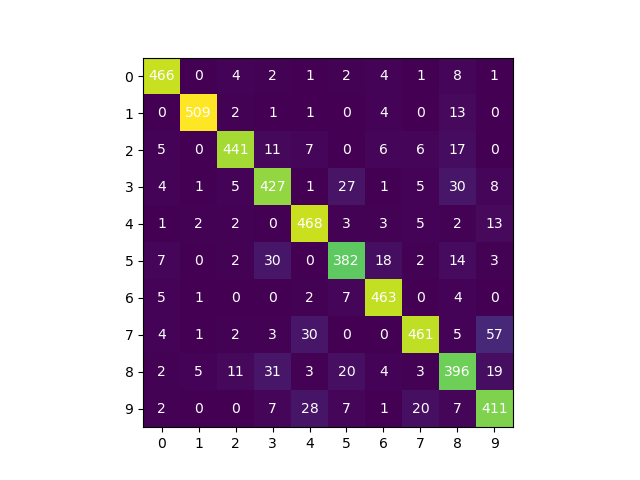

Net RNN_Net Epoch :  1 	 loss : 0.3040543591268901 accuracy : 85.6606
Net RNN_Net Epoch :  2 	 loss : 0.11209808086088763 accuracy : 87.5
Net RNN_Net Epoch :  3 	 loss : 0.09539314560817892 accuracy : 88.68671
Net RNN_Net Epoch :  4 	 loss : 0.1260349940533621 accuracy : 89.042725


<IPython.core.display.Javascript object>


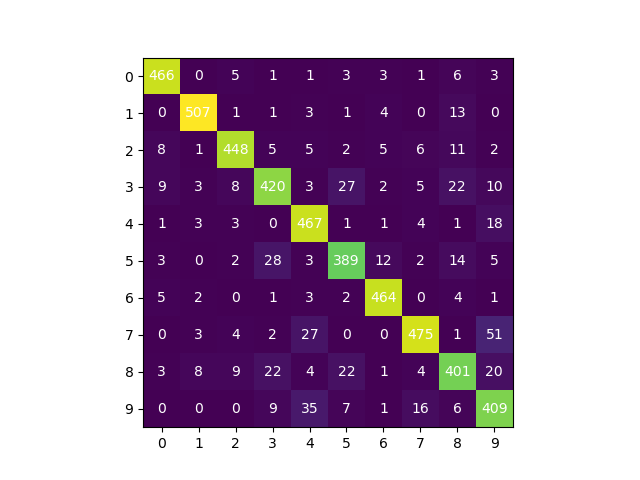

Net RNN_Net Epoch :  1 	 loss : 0.30616247328531254 accuracy : 85.957275
Net RNN_Net Epoch :  2 	 loss : 0.29220887485219293 accuracy : 87.55933
Net RNN_Net Epoch :  3 	 loss : 0.1106599567564591 accuracy : 88.64715
Net RNN_Net Epoch :  4 	 loss : 0.1227848300537216 accuracy : 88.74605


<IPython.core.display.Javascript object>


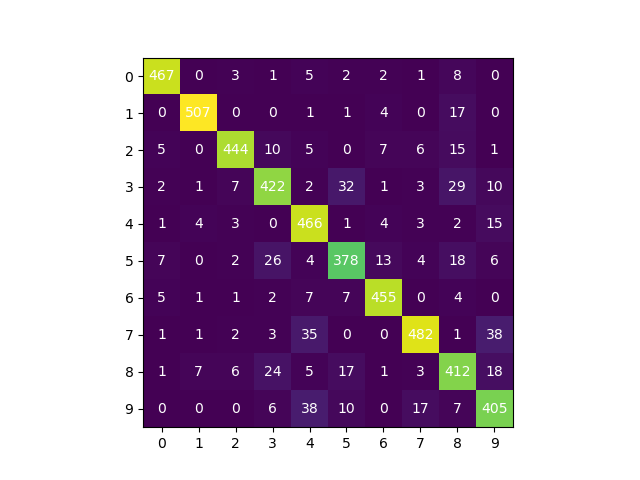

In [12]:
#Get the confusion to see what particular images each trajectory worked best
train_dataloader, test_dataloader, test_dataset = create_dataset(images, labels,res = 6,mixed_state = False)
indices = []
for times in range(10):
    torch.manual_seed(0)
    lr = 3e-3
    epochs = 4
    net = RNN_Net().double()
    #net = CNN().double()
    optimizer = Adam(net.parameters(), lr = lr)
    loss_func = nn.CrossEntropyLoss()
    if torch.cuda.is_available():
        net = net.cuda()

    train_loss = []
    test_loss = []
    test_accur = []
    test_predictions = None
    for epoch in range(epochs):
        batch_loss = []
        for batch_idx, (data,targets) in enumerate(train_dataloader):
            if net.__class__.__name__ == 'RNN_Net':
                data = data.unsqueeze(2)
            if torch.cuda.is_available():
                data = data.to('cuda', non_blocking=True)
                targets = targets.to('cuda', non_blocking = True)
            #print(batch_idx, data.shape, targets.shape)

            optimizer.zero_grad()
            output = net(data.double())
            loss = loss_func(output, targets)
            loss.backward()
            optimizer.step()
            batch_loss.append(loss.item())


        train_loss.append(np.mean(batch_loss))

        if epoch%1 == 0:
            correct = 0
            test_batch_loss = []
            test_accuracy = []
            for batch_idx, (test_data,test_targets) in enumerate(test_dataloader):
                if net.__class__.__name__ == 'RNN_Net':
                    test_data = test_data.unsqueeze(2)
                if torch.cuda.is_available():
                    test_data = test_data.to('cuda', non_blocking=True)
                    test_targets = test_targets.to('cuda', non_blocking = True)
                #print(batch_idx, data.shape, targets.shape)

                test_output = net(test_data)
                loss = loss_func(test_output, test_targets)
                test_batch_loss.append(loss.item())
                test_pred = test_output.data.max(1, keepdim = True)[1]
                correct = test_pred.eq(test_targets.data.view_as(test_pred)).sum()
                test_accuracy.append(100.*correct.to('cpu')/len(test_targets))
                if batch_idx == 0:
                    test_predictions = test_pred.squeeze(1)
                else:
                    test_predictions = torch.cat((test_predictions, test_pred.squeeze(1)), dim = 0)

            print('Net',net.__class__.__name__,'Epoch : ',epoch+1, '\t', 'loss :', loss.to('cpu').item(), 'accuracy :',np.mean(test_accuracy) )
            test_loss.append(np.mean(test_batch_loss))
            test_accur.append(np.mean(test_accuracy))
    #plot confusion matricx and extract the indices where the mistakes where made 
    test_predictions = test_predictions.cpu().detach().numpy().tolist()
    #test_predictions.tolist()
    targets = test_dataset.labels.tolist()
    confusion = confusion_matrix(targets, test_predictions)

    fig, ax = plt.subplots()
    im = ax.imshow(confusion)
    ax.set_xticks(np.arange(10))
    ax.set_yticks(np.arange(10))
    ax.set_xticklabels(np.arange(0,10))
    ax.set_yticklabels(np.arange(0,10))
    plt.savefig('no_restart_{}.png'.format(times))
    # Loop over data dimensions and create text annotations.
    for i in range(10):
        for j in range(10):
            text = ax.text(j, i, confusion[i, j],
                           ha="center", va="center", color="w")
    mistaken = np.where(np.array(test_predictions) != np.array(targets))[0].tolist()
    indices.append(mistaken)



In [13]:
#Build a matrix to hold the number of shared indices where the network was wrong (0d), number of overall 
#mistakes for trajectory i is on the diagonal
indices1 = indices*1
particular_confusion1 = np.ones([len(indices1), len(indices1)])
for i in range(len(indices1)):
    for j in range(len(indices1)):
        particular_confusion1[i,j] = len([r for r in indices1[i] if r in indices1[j]])
particular_confusion1

array([[559., 394., 405., 406., 405., 410., 395., 411., 407., 414.],
       [394., 580., 398., 394., 407., 397., 394., 423., 394., 417.],
       [405., 398., 555., 390., 407., 404., 398., 407., 396., 410.],
       [406., 394., 390., 521., 386., 384., 371., 388., 395., 393.],
       [405., 407., 407., 386., 582., 402., 384., 425., 409., 412.],
       [410., 397., 404., 384., 402., 548., 388., 407., 392., 398.],
       [395., 394., 398., 371., 384., 388., 522., 392., 383., 398.],
       [411., 423., 407., 388., 425., 407., 392., 576., 410., 420.],
       [407., 394., 396., 395., 409., 392., 383., 410., 554., 411.],
       [414., 417., 410., 393., 412., 398., 398., 420., 411., 562.]])

In [ ]:
1

In [18]:
#Get the overall statistics:
#First, divide by the number of mistakes to get the percentage
for i in range(len(indices1)):
    particular_confusion1[i,:] /= particular_confusion1[i,i]
#get only the lower triangle
mean_confusion1 = np.tril(particular_confusion1, -1)
#Reshape to be a list
mean_confusion1 = mean_confusion1.reshape(particular_confusion1.shape[0] * particular_confusion1.shape[1])
mean_confusion1 = mean_confusion1.tolist()
#Delate all 0's from list
mean_confusion1 = [k for k in mean_confusion1 if k!=0]
#Now get the mean
mean_confusion1 = np.mean(mean_confusion1)
print(mean_confusion1)
    

0.7225630017893904


In [14]:
#Find the differences for each particular label - ex. for label 5 what missclassification did run 1 did 
#compared to run 2? i.e. can we find a trajectory that was particularly different for a distinct class? 
#or are all the classes exsibit simillar veriance? 
very_particular_confusion1 = np.ones([10,len(indices), len(indices)])
for i in range(len(indices1)):
    for j in range(len(indices1)):
            for class_ in range(10):
                class_indices = np.where(np.array(test_dataset.labels) == np.array(class_))[0]
                #get only the misslabeled indices for class_ from i
                i_indices = [k for k in indices1[i] if k in class_indices]
                #see how many are similar between i and j in class_
                similar = [l for l in i_indices if l in indices1[j]]
                very_particular_confusion1[class_, i, j] = len(similar)
                
very_particular_confusion1               

array([[[ 26.,  19.,  21.,  19.,  19.,  18.,  19.,  19.,  18.,  18.],
        [ 19.,  24.,  21.,  17.,  21.,  18.,  19.,  21.,  16.,  18.],
        [ 21.,  21.,  27.,  20.,  21.,  18.,  22.,  20.,  18.,  19.],
        [ 19.,  17.,  20.,  24.,  20.,  18.,  18.,  17.,  19.,  17.],
        [ 19.,  21.,  21.,  20.,  25.,  19.,  20.,  19.,  19.,  18.],
        [ 18.,  18.,  18.,  18.,  19.,  22.,  19.,  19.,  17.,  15.],
        [ 19.,  19.,  22.,  18.,  20.,  19.,  23.,  19.,  18.,  17.],
        [ 19.,  21.,  20.,  17.,  19.,  19.,  19.,  23.,  16.,  16.],
        [ 18.,  16.,  18.,  19.,  19.,  17.,  18.,  16.,  23.,  17.],
        [ 18.,  18.,  19.,  17.,  18.,  15.,  17.,  16.,  17.,  22.]],

       [[ 16.,  14.,  12.,  11.,  15.,  13.,  14.,  15.,  13.,  15.],
        [ 14.,  28.,  15.,  15.,  15.,  16.,  19.,  17.,  15.,  19.],
        [ 12.,  15.,  19.,  14.,  14.,  14.,  16.,  14.,  16.,  15.],
        [ 11.,  15.,  14.,  18.,  15.,  14.,  14.,  14.,  15.,  16.],
        [ 15.,  15

In [19]:
#see the percentage of very_particular_confusion1 
for i in range(len(indices1)):
    for class_ in range(10):
        very_particular_confusion1[class_, i, :] /= very_particular_confusion1[class_, i, i] 
        
very_particular_confusion1

array([[[1.        , 0.73076923, 0.80769231, 0.73076923, 0.73076923,
         0.69230769, 0.73076923, 0.73076923, 0.69230769, 0.69230769],
        [0.79166667, 1.        , 0.875     , 0.70833333, 0.875     ,
         0.75      , 0.79166667, 0.875     , 0.66666667, 0.75      ],
        [0.77777778, 0.77777778, 1.        , 0.74074074, 0.77777778,
         0.66666667, 0.81481481, 0.74074074, 0.66666667, 0.7037037 ],
        [0.79166667, 0.70833333, 0.83333333, 1.        , 0.83333333,
         0.75      , 0.75      , 0.70833333, 0.79166667, 0.70833333],
        [0.76      , 0.84      , 0.84      , 0.8       , 1.        ,
         0.76      , 0.8       , 0.76      , 0.76      , 0.72      ],
        [0.81818182, 0.81818182, 0.81818182, 0.81818182, 0.86363636,
         1.        , 0.86363636, 0.86363636, 0.77272727, 0.68181818],
        [0.82608696, 0.82608696, 0.95652174, 0.7826087 , 0.86956522,
         0.82608696, 1.        , 0.82608696, 0.7826087 , 0.73913043],
        [0.82608696, 0.9130

### See the changes from different trajectories - are they more sugnificant then the random ones? 

<IPython.core.display.Javascript object>


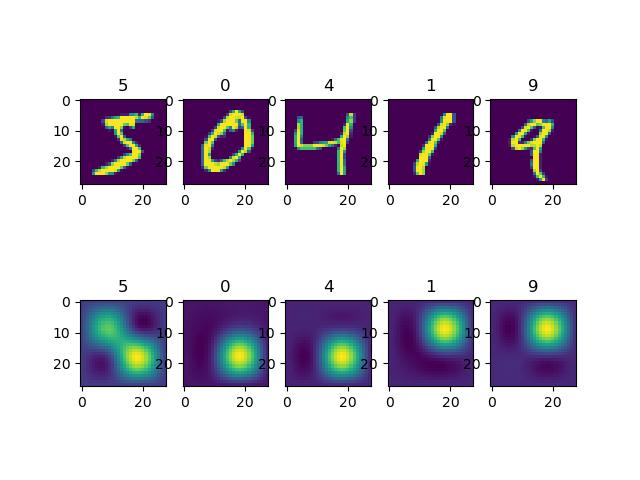

Net RNN_Net Epoch :  1 	 loss : 0.5843339952650805 accuracy : 82.59494
Net RNN_Net Epoch :  2 	 loss : 0.2943757929671916 accuracy : 84.81013
Net RNN_Net Epoch :  3 	 loss : 0.6967343734795369 accuracy : 86.273735
Net RNN_Net Epoch :  4 	 loss : 0.5181512968396073 accuracy : 86.96598


<IPython.core.display.Javascript object>


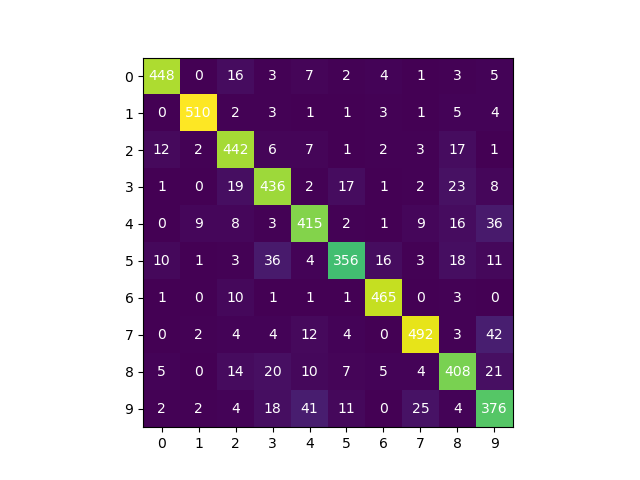

<IPython.core.display.Javascript object>


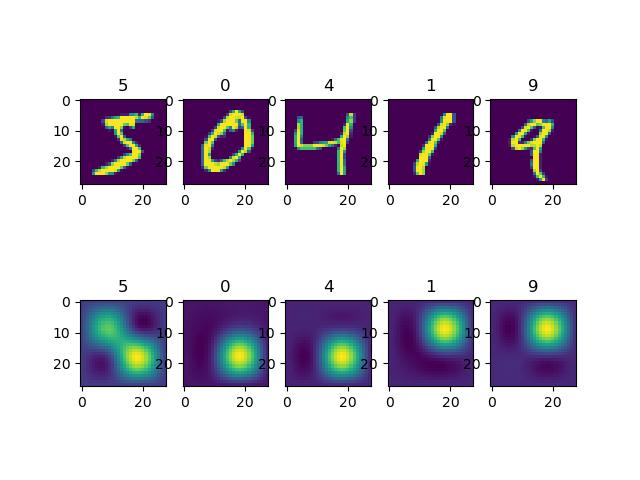

Net RNN_Net Epoch :  1 	 loss : 0.17053654208228797 accuracy : 85.36392
Net RNN_Net Epoch :  2 	 loss : 0.232269936063852 accuracy : 87.7769
Net RNN_Net Epoch :  3 	 loss : 0.04708286793766608 accuracy : 89.24051
Net RNN_Net Epoch :  4 	 loss : 0.05550987197011428 accuracy : 89.63608


<IPython.core.display.Javascript object>


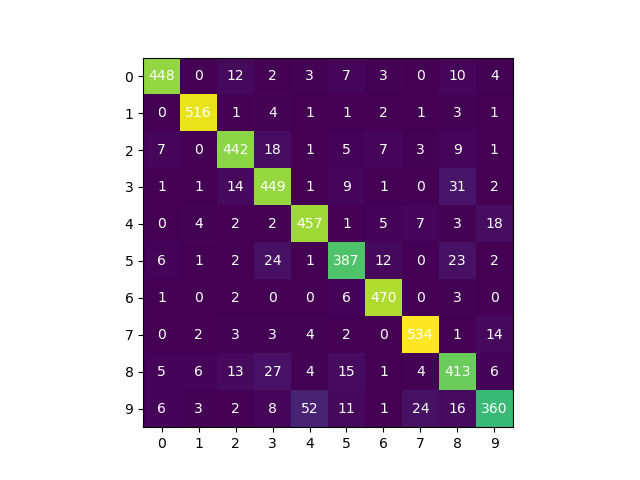

<IPython.core.display.Javascript object>


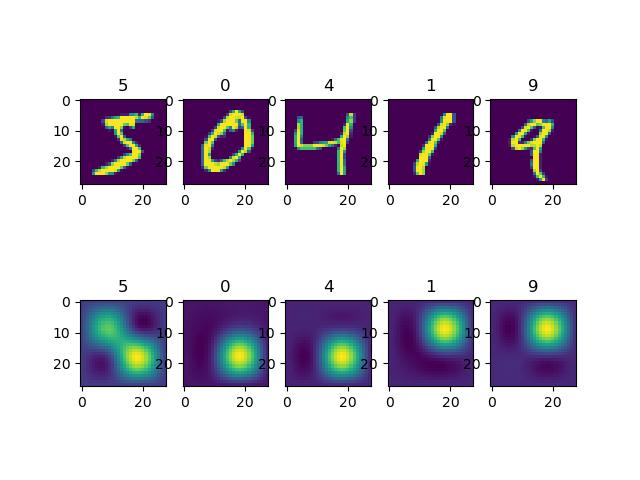

Net RNN_Net Epoch :  1 	 loss : 0.15697315011484456 accuracy : 84.79035
Net RNN_Net Epoch :  2 	 loss : 0.2407195801847146 accuracy : 87.14399
Net RNN_Net Epoch :  3 	 loss : 0.18541981341239272 accuracy : 88.62737
Net RNN_Net Epoch :  4 	 loss : 0.14884639211012027 accuracy : 88.39003


<IPython.core.display.Javascript object>


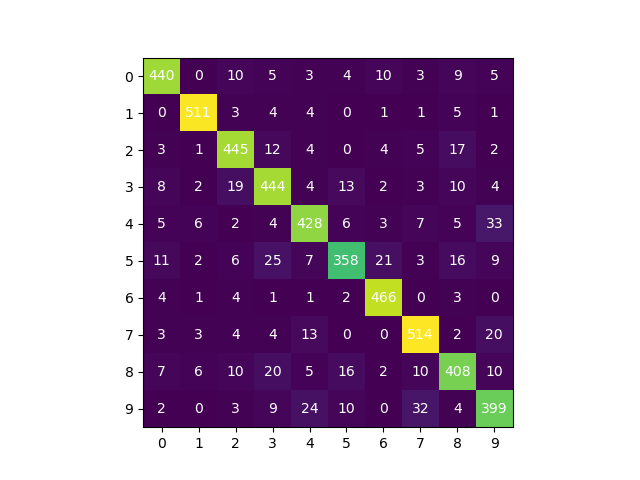

<IPython.core.display.Javascript object>


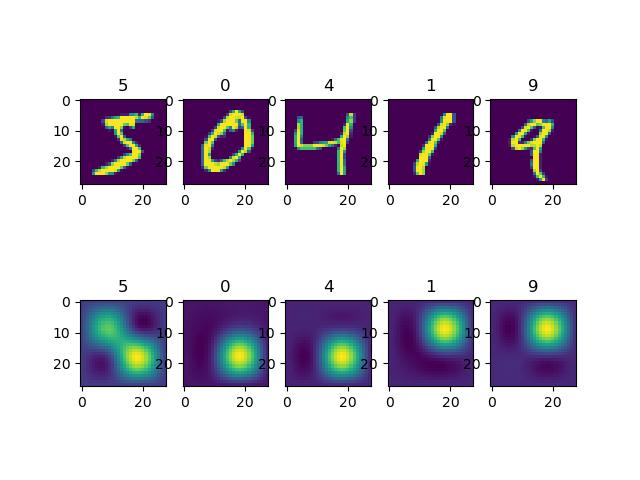

Net RNN_Net Epoch :  1 	 loss : 0.7140893730684168 accuracy : 78.08544
Net RNN_Net Epoch :  2 	 loss : 0.4987484741661362 accuracy : 82.02136
Net RNN_Net Epoch :  3 	 loss : 0.5061305230287947 accuracy : 82.832275
Net RNN_Net Epoch :  4 	 loss : 0.5949724949436708 accuracy : 84.41456


<IPython.core.display.Javascript object>


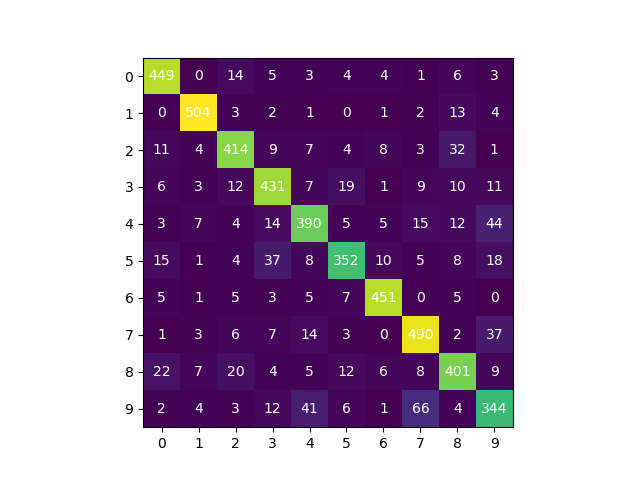

<IPython.core.display.Javascript object>


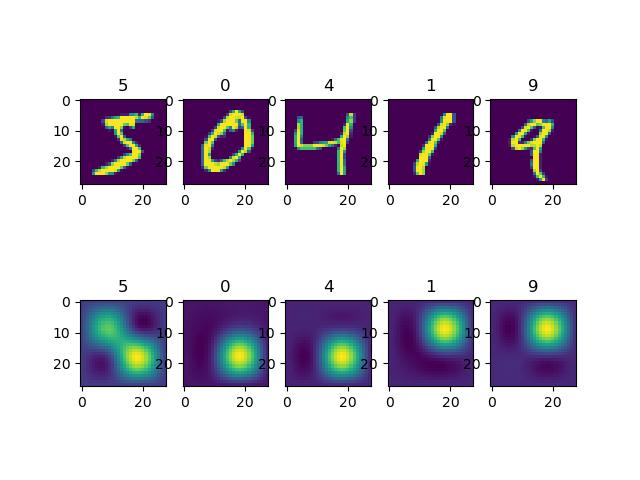

Net RNN_Net Epoch :  1 	 loss : 0.45379152157977637 accuracy : 79.64794
Net RNN_Net Epoch :  2 	 loss : 0.8172513597339051 accuracy : 81.56645
Net RNN_Net Epoch :  3 	 loss : 0.4497721696095281 accuracy : 82.73338
Net RNN_Net Epoch :  4 	 loss : 0.9072145952324391 accuracy : 82.73338


<ipython-input-15-713886ede709>:72: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


<IPython.core.display.Javascript object>


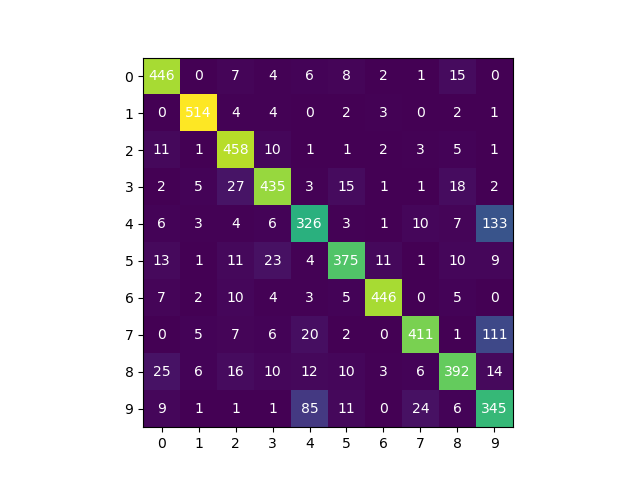

<IPython.core.display.Javascript object>


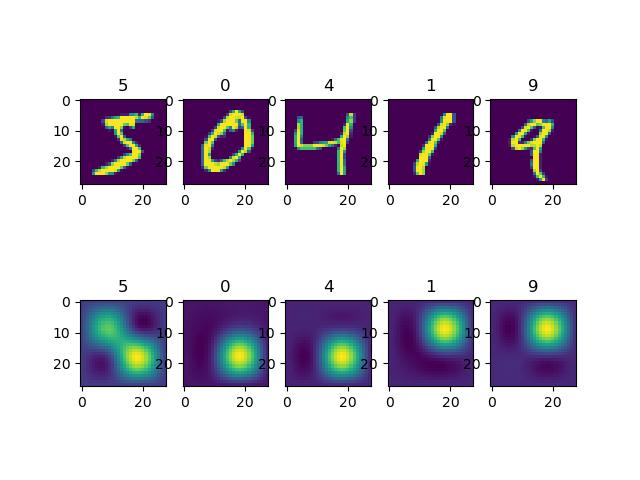

Net RNN_Net Epoch :  1 	 loss : 0.4120740004680042 accuracy : 87.38133
Net RNN_Net Epoch :  2 	 loss : 0.2828875270375766 accuracy : 89.29984
Net RNN_Net Epoch :  3 	 loss : 0.0878782062265232 accuracy : 90.38766
Net RNN_Net Epoch :  4 	 loss : 0.041413053015502924 accuracy : 90.44699


<IPython.core.display.Javascript object>


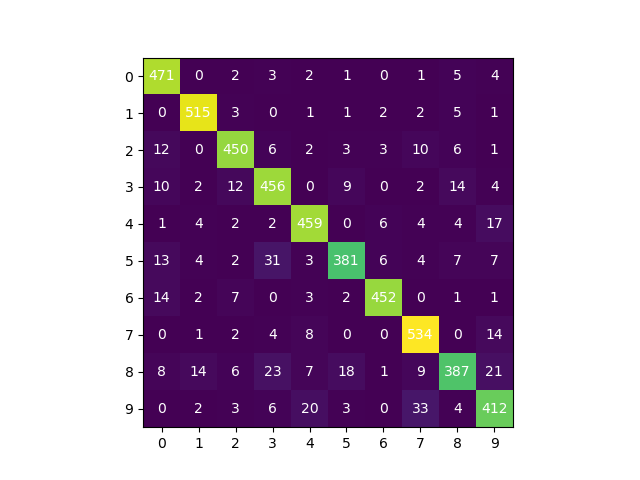

<IPython.core.display.Javascript object>


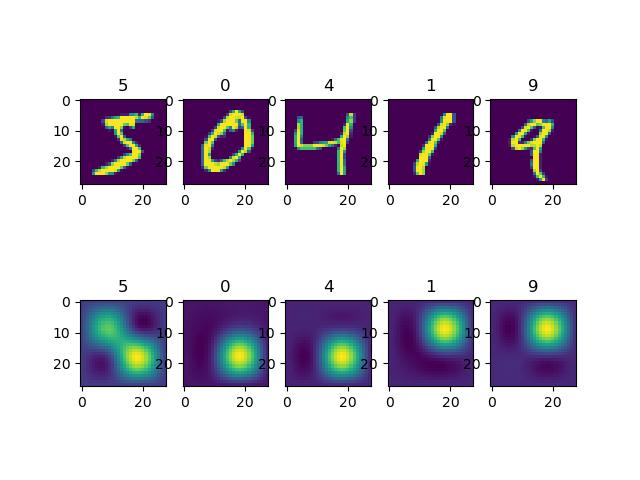

Net RNN_Net Epoch :  1 	 loss : 0.2984357045142204 accuracy : 85.462814
Net RNN_Net Epoch :  2 	 loss : 0.2580857030780787 accuracy : 87.5
Net RNN_Net Epoch :  3 	 loss : 0.15662039068584066 accuracy : 88.70649
Net RNN_Net Epoch :  4 	 loss : 0.05131724081345122 accuracy : 88.92405


<IPython.core.display.Javascript object>


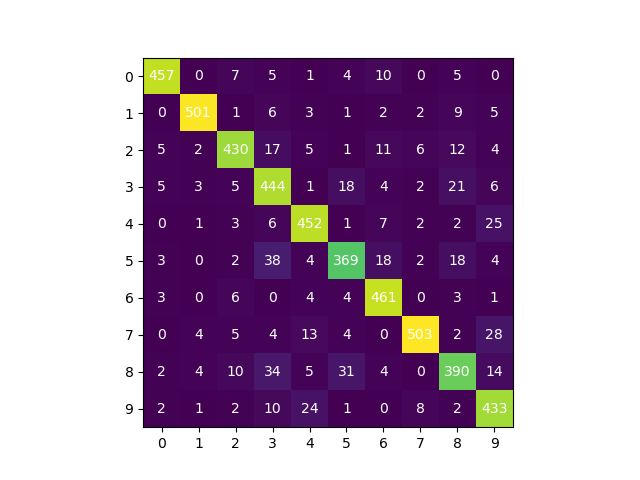

<IPython.core.display.Javascript object>


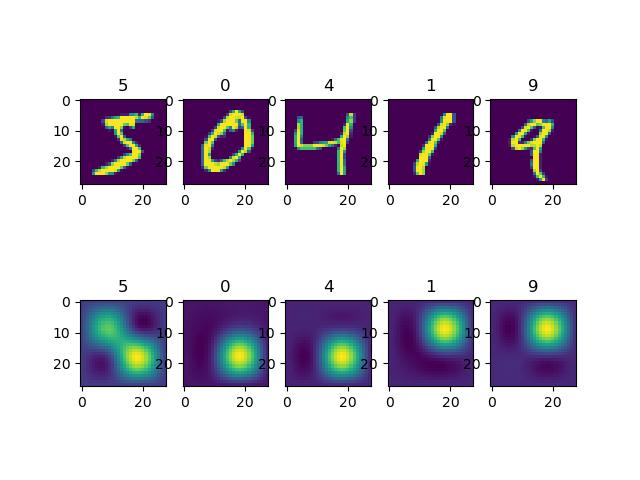

Net RNN_Net Epoch :  1 	 loss : 0.19488875864667637 accuracy : 86.55064
Net RNN_Net Epoch :  2 	 loss : 0.4506692013548713 accuracy : 87.73734
Net RNN_Net Epoch :  3 	 loss : 0.04061647261151383 accuracy : 89.260284
Net RNN_Net Epoch :  4 	 loss : 0.2704976512973596 accuracy : 89.576744


<IPython.core.display.Javascript object>


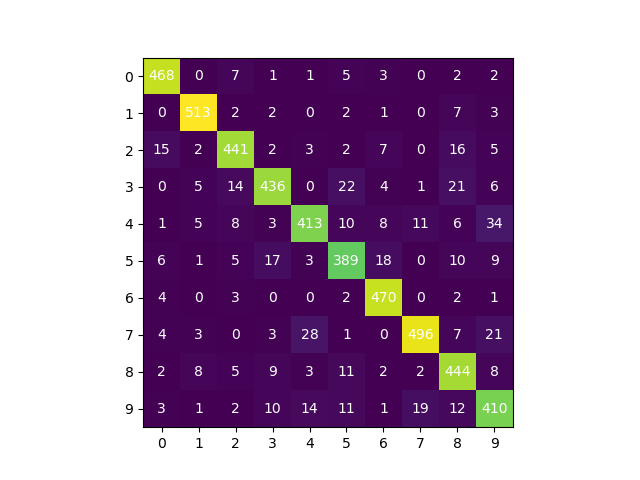

<IPython.core.display.Javascript object>


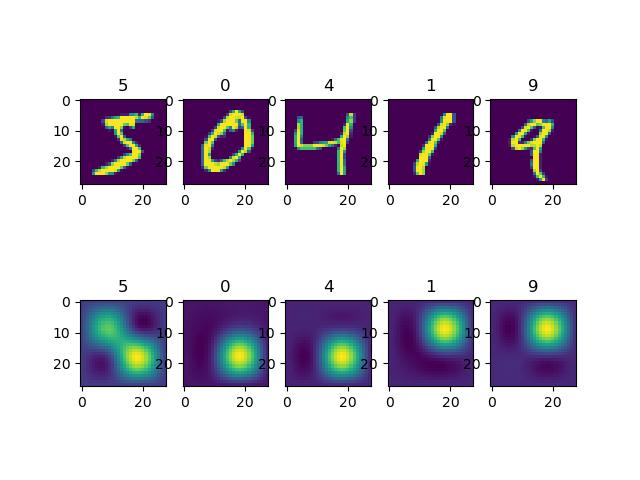

Net RNN_Net Epoch :  1 	 loss : 0.4577433807271368 accuracy : 82.69383
Net RNN_Net Epoch :  2 	 loss : 0.23593588335780052 accuracy : 86.33307
Net RNN_Net Epoch :  3 	 loss : 0.24067731880435542 accuracy : 86.92642
Net RNN_Net Epoch :  4 	 loss : 0.143317172519786 accuracy : 87.0451


<IPython.core.display.Javascript object>


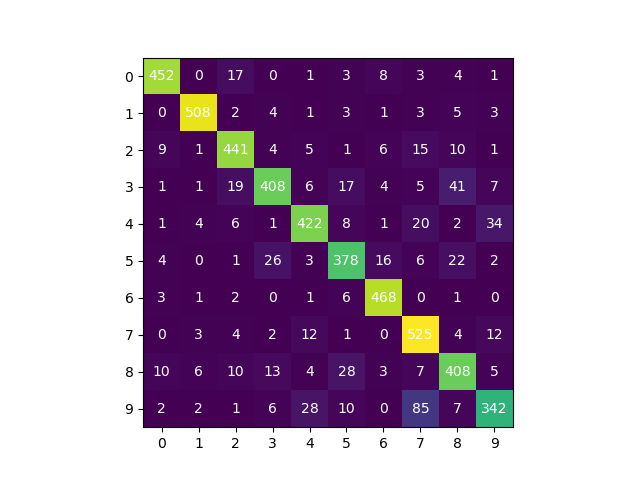

<IPython.core.display.Javascript object>


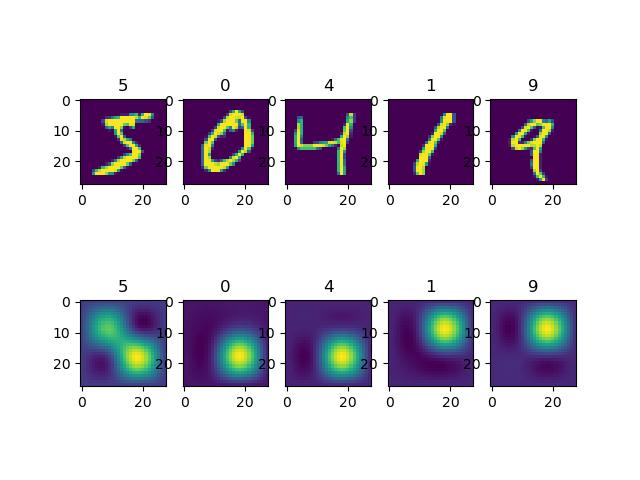

Net RNN_Net Epoch :  1 	 loss : 0.28760270283176487 accuracy : 84.19699
Net RNN_Net Epoch :  2 	 loss : 0.0997919745035408 accuracy : 87.99446
Net RNN_Net Epoch :  3 	 loss : 0.1679090890019845 accuracy : 88.82516
Net RNN_Net Epoch :  4 	 loss : 0.18657984621647614 accuracy : 88.726265


<IPython.core.display.Javascript object>


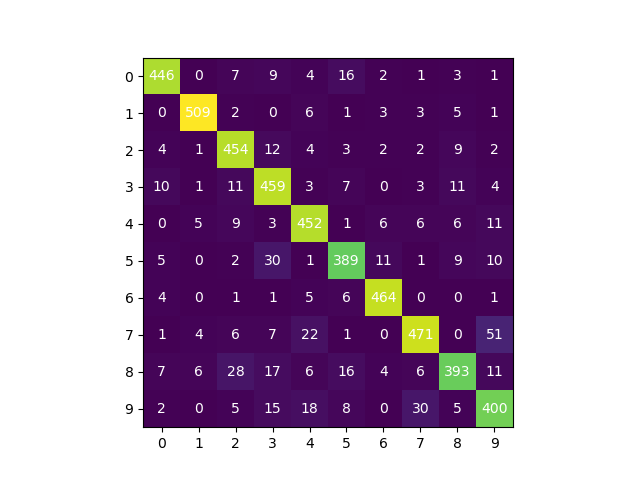

In [15]:
#Get the confusion to see what particular images each trajectory worked best
torch.manual_seed(0)
indices = []
for times in range(10):
    #Load the training data
    train_dataloader, test_dataloader, test_dataset = create_dataset(images, labels,res = 6,mixed_state = False)
    lr = 3e-3
    epochs = 4
    net = RNN_Net().double()
    #net = CNN().double()
    optimizer = Adam(net.parameters(), lr = lr)
    loss_func = nn.CrossEntropyLoss()
    if torch.cuda.is_available():
        net = net.cuda()

    train_loss = []
    test_loss = []
    test_accur = []
    test_predictions = None
    for epoch in range(epochs):
        batch_loss = []
        for batch_idx, (data,targets) in enumerate(train_dataloader):
            if net.__class__.__name__ == 'RNN_Net':
                data = data.unsqueeze(2)
            if torch.cuda.is_available():
                data = data.to('cuda', non_blocking=True)
                targets = targets.to('cuda', non_blocking = True)
            #print(batch_idx, data.shape, targets.shape)

            optimizer.zero_grad()
            output = net(data.double())
            loss = loss_func(output, targets)
            loss.backward()
            optimizer.step()
            batch_loss.append(loss.item())


        train_loss.append(np.mean(batch_loss))

        if epoch%1 == 0:
            correct = 0
            test_batch_loss = []
            test_accuracy = []
            for batch_idx, (test_data,test_targets) in enumerate(test_dataloader):
                if net.__class__.__name__ == 'RNN_Net':
                    test_data = test_data.unsqueeze(2)
                if torch.cuda.is_available():
                    test_data = test_data.to('cuda', non_blocking=True)
                    test_targets = test_targets.to('cuda', non_blocking = True)
                #print(batch_idx, data.shape, targets.shape)

                test_output = net(test_data)
                loss = loss_func(test_output, test_targets)
                test_batch_loss.append(loss.item())
                test_pred = test_output.data.max(1, keepdim = True)[1]
                correct = test_pred.eq(test_targets.data.view_as(test_pred)).sum()
                test_accuracy.append(100.*correct.to('cpu')/len(test_targets))
                if batch_idx == 0:
                    test_predictions = test_pred.squeeze(1)
                else:
                    test_predictions = torch.cat((test_predictions, test_pred.squeeze(1)), dim = 0)

            print('Net',net.__class__.__name__,'Epoch : ',epoch+1, '\t', 'loss :', loss.to('cpu').item(), 'accuracy :',np.mean(test_accuracy) )
            test_loss.append(np.mean(test_batch_loss))
            test_accur.append(np.mean(test_accuracy))
    #plot confusion matricx and extract the indices where the mistakes where made 
    test_predictions = test_predictions.cpu().detach().numpy().tolist()
    #test_predictions.tolist()
    targets = test_dataset.labels.tolist()
    confusion = confusion_matrix(targets, test_predictions)

    fig, ax = plt.subplots()
    im = ax.imshow(confusion)
    ax.set_xticks(np.arange(10))
    ax.set_yticks(np.arange(10))
    ax.set_xticklabels(np.arange(0,10))
    ax.set_yticklabels(np.arange(0,10))
    plt.savefig('with_restart_{}.png'.format(times))
    # Loop over data dimensions and create text annotations.
    for i in range(10):
        for j in range(10):
            text = ax.text(j, i, confusion[i, j],
                           ha="center", va="center", color="w")
    mistaken = np.where(np.array(test_predictions) != np.array(targets))[0].tolist()
    indices.append(mistaken)



In [16]:
#Build a 3d matrix to hold the number of shared indices where the network was wrong (0d), number of overall 
#mistakes for trajectory i is on the diagonal
indices2 = indices*1
particular_confusion2 = np.ones([len(indices), len(indices)])
for i in range(len(indices)):
    for j in range(len(indices)):
        particular_confusion2[i,j] = len([r for r in indices[i] if r in indices[j]])
particular_confusion2

array([[652., 211., 232., 286., 282., 209., 214., 246., 271., 232.],
       [211., 524., 224., 232., 246., 204., 227., 175., 212., 218.],
       [232., 224., 587., 261., 263., 212., 229., 234., 232., 224.],
       [286., 232., 261., 774., 338., 209., 242., 249., 290., 265.],
       [282., 246., 263., 338., 852., 220., 237., 264., 283., 285.],
       [209., 204., 212., 209., 220., 483., 206., 185., 202., 218.],
       [214., 227., 229., 242., 237., 206., 560., 211., 253., 233.],
       [246., 175., 234., 249., 264., 185., 211., 520., 227., 211.],
       [271., 212., 232., 290., 283., 202., 253., 227., 648., 215.],
       [232., 218., 224., 265., 285., 218., 233., 211., 215., 563.]])

In [20]:
#Get the overall statistics:
#First, divide by the number of mistakes to get the percentage
for i in range(len(indices2)):
    particular_confusion2[i,:] /= particular_confusion2[i,i]
#get only the lower triangle
mean_confusion2 = np.tril(particular_confusion2, -1)
#Reshape to be a list
mean_confusion2 = mean_confusion2.reshape(particular_confusion2.shape[0] * particular_confusion2.shape[1])
mean_confusion2 = mean_confusion2.tolist()
#Delate all 0's from list
mean_confusion2 = [k for k in mean_confusion2 if k!=0]
#Now get the mean
mean_confusion2 = np.mean(mean_confusion2)
print(mean_confusion2)


0.3976117248953331


In [17]:
#Find the differences for each particular label - ex. for label 5 what missclassification did run 1 did 
#compared to run 2? i.e. can we find a trajectory that was particularly different for a distinct class? 
#or are all the classes exsibit simillar veriance? 
very_particular_confusion2 = np.ones([10,len(indices2), len(indices2)])
for i in range(len(indices2)):
    for j in range(len(indices2)):
            for class_ in range(10):
                class_indices = np.where(np.array(test_dataset.labels) == np.array(class_))[0]
                #get only the misslabeled indices for class_ from i
                i_indices = [k for k in indices2[i] if k in class_indices]
                #see how many are similar between i and j in class_
                similar = [l for l in i_indices if l in indices2[j]]
                very_particular_confusion2[class_, i, j] = len(similar)
                
very_particular_confusion2

array([[[ 41.,  17.,  19.,  16.,  17.,  13.,  14.,  13.,  17.,  21.],
        [ 17.,  41.,  18.,  16.,  20.,  14.,  16.,  12.,  16.,  17.],
        [ 19.,  18.,  49.,  21.,  16.,  12.,  20.,  14.,  22.,  19.],
        [ 16.,  16.,  21.,  40.,  13.,  12.,  14.,  12.,  15.,  17.],
        [ 17.,  20.,  16.,  13.,  43.,  12.,  13.,  12.,  15.,  16.],
        [ 13.,  14.,  12.,  12.,  12.,  18.,  11.,  11.,  14.,  14.],
        [ 14.,  16.,  20.,  14.,  13.,  11.,  32.,  13.,  16.,  17.],
        [ 13.,  12.,  14.,  12.,  12.,  11.,  13.,  21.,  14.,  15.],
        [ 17.,  16.,  22.,  15.,  15.,  14.,  16.,  14.,  37.,  16.],
        [ 21.,  17.,  19.,  17.,  16.,  14.,  17.,  15.,  16.,  43.]],

       [[ 20.,   6.,  11.,  11.,  10.,   8.,  12.,  10.,  12.,  11.],
        [  6.,  14.,   8.,  10.,  10.,   6.,  10.,   6.,   9.,  10.],
        [ 11.,   8.,  19.,  14.,  10.,   8.,  14.,  12.,  14.,  15.],
        [ 11.,  10.,  14.,  26.,  11.,   7.,  17.,  10.,  15.,  15.],
        [ 10.,  10

In [21]:
#see the percentage of very_particular_confusion1 
for i in range(len(indices2)):
    for class_ in range(10):
        very_particular_confusion2[class_, i, :] /= very_particular_confusion2[class_, i, i] 
        
very_particular_confusion2 = np.round(very_particular_confusion2, decimals = 2
very_particular_confusion2                                  

array([[[1.        , 0.41463415, 0.46341463, 0.3902439 , 0.41463415,
         0.31707317, 0.34146341, 0.31707317, 0.41463415, 0.51219512],
        [0.41463415, 1.        , 0.43902439, 0.3902439 , 0.48780488,
         0.34146341, 0.3902439 , 0.29268293, 0.3902439 , 0.41463415],
        [0.3877551 , 0.36734694, 1.        , 0.42857143, 0.32653061,
         0.24489796, 0.40816327, 0.28571429, 0.44897959, 0.3877551 ],
        [0.4       , 0.4       , 0.525     , 1.        , 0.325     ,
         0.3       , 0.35      , 0.3       , 0.375     , 0.425     ],
        [0.39534884, 0.46511628, 0.37209302, 0.30232558, 1.        ,
         0.27906977, 0.30232558, 0.27906977, 0.34883721, 0.37209302],
        [0.72222222, 0.77777778, 0.66666667, 0.66666667, 0.66666667,
         1.        , 0.61111111, 0.61111111, 0.77777778, 0.77777778],
        [0.4375    , 0.5       , 0.625     , 0.4375    , 0.40625   ,
         0.34375   , 1.        , 0.40625   , 0.5       , 0.53125   ],
        [0.61904762, 0.5714

In [29]:
very_particular_confusion2 = np.round(very_particular_confusion2, decimals = 2)
very_particular_confusion2  

array([[[1.  , 0.41, 0.46, 0.39, 0.41, 0.32, 0.34, 0.32, 0.41, 0.51],
        [0.41, 1.  , 0.44, 0.39, 0.49, 0.34, 0.39, 0.29, 0.39, 0.41],
        [0.39, 0.37, 1.  , 0.43, 0.33, 0.24, 0.41, 0.29, 0.45, 0.39],
        [0.4 , 0.4 , 0.52, 1.  , 0.32, 0.3 , 0.35, 0.3 , 0.38, 0.42],
        [0.4 , 0.47, 0.37, 0.3 , 1.  , 0.28, 0.3 , 0.28, 0.35, 0.37],
        [0.72, 0.78, 0.67, 0.67, 0.67, 1.  , 0.61, 0.61, 0.78, 0.78],
        [0.44, 0.5 , 0.62, 0.44, 0.41, 0.34, 1.  , 0.41, 0.5 , 0.53],
        [0.62, 0.57, 0.67, 0.57, 0.57, 0.52, 0.62, 1.  , 0.67, 0.71],
        [0.46, 0.43, 0.59, 0.41, 0.41, 0.38, 0.43, 0.38, 1.  , 0.43],
        [0.49, 0.4 , 0.44, 0.4 , 0.37, 0.33, 0.4 , 0.35, 0.37, 1.  ]],

       [[1.  , 0.3 , 0.55, 0.55, 0.5 , 0.4 , 0.6 , 0.5 , 0.6 , 0.55],
        [0.43, 1.  , 0.57, 0.71, 0.71, 0.43, 0.71, 0.43, 0.64, 0.71],
        [0.58, 0.42, 1.  , 0.74, 0.53, 0.42, 0.74, 0.63, 0.74, 0.79],
        [0.42, 0.38, 0.54, 1.  , 0.42, 0.27, 0.65, 0.38, 0.58, 0.58],
        [0.62, 0.6

In [2]:
import numpy as np
print(np.mean([41,41,49,40,43,18,32,21,37,43]), np.std([41,41,49,40,43,18,32,21,37,43]),np.argmin([41,41,49,40,43,18,32,21,37,43]))

print(np.mean([20,14,19,26,16,15,29,17,22,21]), np.std([20,14,19,26,16,15,29,17,22,21]),np.argmin([20,14,19,26,16,15,29,17,22,21]))

print(np.mean([51,51,48,79,35,43,63,52,52,39]), np.std([51,51,48,79,35,43,63,52,52,39]),np.argmin([51,51,48,79,35,43,63,52,52,39]))

print(np.mean([73,60,65,78,74,53,65,73,101,50]), np.std([73,60,65,78,74,53,65,73,101,50]),np.argmin([73,60,65,78,74,53,65,73,101,50]))

print(np.mean([84,42,71,109,173,40,47,86,77,47]), np.std([84,42,71,109,173,40,47,86,77,47]),np.argmin([84,42,71,109,173,40,47,86,77,47]))

print(np.mean([102,71,100,106,83,77,89,69,80,69]), np.std([102,71,100,106,83,77,89,69,80,69]),np.argmin([102,71,100,106,83,77,89,69,80,69]))

print(np.mean([17,12,16,31,36,30,21,12,14,18]), np.std([17,12,16,31,36,30,21,12,14,18]),np.argmin([17,12,16,31,36,30,21,12,14,18]))

print(np.mean([71,29,49,73,152,29,60,67,38,92]), np.std([71,29,49,73,152,29,60,67,38,92]), np.argmin([71,29,49,73,152,29,60,67,38,92]))

print(np.mean([86,81,86,93,102,107,104,50,86,101]), np.std([86,81,86,93,102,107,104,50,86,101]), np.argmin([86,81,86,93,102,107,104,50,86,101]))

print(np.mean([107,123,84,139,138,71,50,73,141,83]), np.std([107,123,84,139,138,71,50,73,141,83]),np.argmin([107,123,84,139,138,71,50,73,141,83]))

36.5 9.468368391650168 5
19.9 4.570557952810575 1
51.3 11.841030360572512 4
69.2 13.753544997563356 9
77.6 38.466088961577576 5
84.6 13.305637902783918 7
20.7 8.161494961096281 1
66.0 34.63235481453723 1
89.6 15.768322675541619 7
100.9 31.354266057428294 6


In [69]:
def plot_confusion(test_predictions,test_dataset):
    test_predictions = test_predictions.cpu().detach().numpy().tolist()
    #test_predictions.tolist()
    labels = test_dataset.labels.tolist()
    confusion = confusion_matrix(labels, test_predictions)

    fig, ax = plt.subplots()
    im = ax.imshow(confusion)
    ax.set_xticks(np.arange(10))
    ax.set_yticks(np.arange(10))
    ax.set_xticklabels(np.arange(0,10))
    ax.set_yticklabels(np.arange(0,10))
    # Loop over data dimensions and create text annotations.
    for i in range(10):
        for j in range(10):
            text = ax.text(j, i, confusion[i, j],
                           ha="center", va="center", color="w")